# Multiclass - Multilabel Problem - find Pet category, breed category

## Import Packages

In [1]:
# Common imports for data
import numpy as np
import pandas as pd
import os

# for metrics, preprocessing
import sklearn


# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot 
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


## Download the Data

In [2]:
os.chdir("/Users/vivekkathula/Documents/Competitions/Pet Adoption HackerEarth/Dataset_HE_PetAdoption/")
train=pd.read_csv("HE_PetAdoption_train.csv")
test=pd.read_csv("HE_PetAdoption_test.csv")

## Make a copy of train and test, so we can come back to original

In [3]:
pet_train_full=train.copy()
pet_test=test.copy()

## Take a Quick Look at the Data Structure

In [4]:
pet_train_full.head(3)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
0,ANSL_69903,2016-07-10 00:00:00,2016-09-21 16:25:00,2.0,Brown Tabby,0.80,7.78,13,9,0.0,1
1,ANSL_66892,2013-11-21 00:00:00,2018-12-27 17:47:00,1.0,White,0.72,14.19,13,9,0.0,2
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.90,15,4,2.0,4


In [5]:
pet_train_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18834 entries, 0 to 18833
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pet_id          18834 non-null  object 
 1   issue_date      18834 non-null  object 
 2   listing_date    18834 non-null  object 
 3   condition       17357 non-null  float64
 4   color_type      18834 non-null  object 
 5   length(m)       18834 non-null  float64
 6   height(cm)      18834 non-null  float64
 7   X1              18834 non-null  int64  
 8   X2              18834 non-null  int64  
 9   breed_category  18834 non-null  float64
 10  pet_category    18834 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 1.6+ MB


In [6]:
pet_train_full.color_type.value_counts()

Black                4620
White                2453
Brown                1791
Brown Tabby          1687
Tan                  1349
Blue                  852
Orange Tabby          791
Red                   526
Brown Brindle         496
Tricolor              469
Blue Tabby            386
Tortie                366
Calico                343
Gray                  307
Chocolate             259
Torbie                242
Cream Tabby           191
Sable                 167
Cream                 162
Fawn                  159
Yellow                143
Buff                  125
Lynx Point            117
Blue Merle            104
Seal Point             78
Black Brindle          66
Gray Tabby             65
Black Tabby            55
Flame Point            52
Orange                 39
Brown Merle            39
Black Smoke            32
Gold                   31
Tortie Point           26
Silver                 24
Red Tick               23
Blue Tick              21
Blue Point             20
Lilac Point 

In [7]:
pet_train_full.describe()

,condition,length(m),height(cm),X1,X2,breed_category,pet_category
count,17357.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000,18834.000000
mean,0.883390,0.502636,27.448832,5.369598,4.577307,0.600563,1.709143
std,0.770434,0.288705,13.019781,6.572366,3.517763,0.629883,0.717919
min,0.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.250000,16.172500,0.000000,1.000000,0.000000,1.000000
50%,1.000000,0.500000,27.340000,0.000000,4.000000,1.000000,2.000000
75%,1.000000,0.760000,38.890000,13.000000,9.000000,1.000000,2.000000
max,2.000000,1.000000,50.000000,19.000000,9.000000,2.000000,4.000000


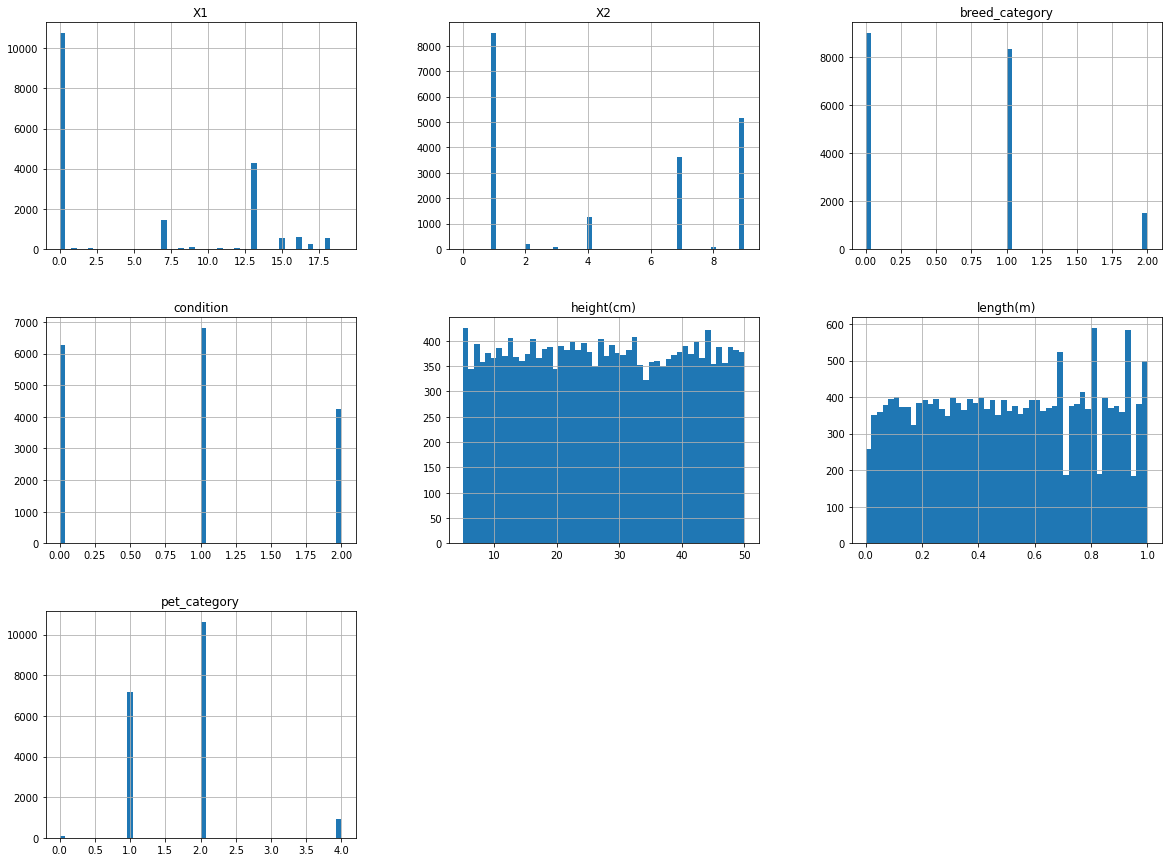

In [8]:
pet_train_full.hist(bins=50, figsize=(20,15)) 
plt.show()

In [9]:
pet_train_full.isnull().sum()

pet_id               0
issue_date           0
listing_date         0
condition         1477
color_type           0
length(m)            0
height(cm)           0
X1                   0
X2                   0
breed_category       0
pet_category         0
dtype: int64

In [10]:
pet_train_full.corr()["breed_category"].sort_values(ascending=False)

breed_category    1.000000
X1                0.240729
pet_category      0.209230
X2                0.052530
height(cm)        0.011647
length(m)         0.007229
condition        -0.483503
Name: breed_category, dtype: float64

In [11]:
pet_train_full[pet_train_full.condition.isnull()].head(3)

,pet_id,issue_date,listing_date,condition,color_type,length(m),height(cm),X1,X2,breed_category,pet_category
2,ANSL_69750,2014-09-28 00:00:00,2016-10-19 08:24:00,NaN,Brown,0.15,40.9,15,4,2.0,4
21,ANSL_50488,2018-01-07 00:00:00,2018-07-28 12:36:00,NaN,Brown,0.45,14.0,11,4,2.0,4
35,ANSL_54000,2018-01-14 00:00:00,2018-02-11 14:49:00,NaN,White,0.03,21.9,13,9,2.0,1


In [12]:
pet_train_full[pet_train_full.condition.isnull()].breed_category.value_counts()

2.0    1477
Name: breed_category, dtype: int64

### There are a few things you might notice 
#### 1) condition has a lot influence on breed, and all missing values in condition have same breed type, so replace the missing value with a 3.0 

### Create a valid Set

#### Stratified split would have been great but within colortype we have very few categories (like 1 twice)

In [13]:
from sklearn.model_selection import train_test_split
train_set, valid_set = train_test_split(pet_train_full, test_size=0.2, random_state=42)

In [14]:
pet_train = train_set.copy()
pet_valid = valid_set.copy()

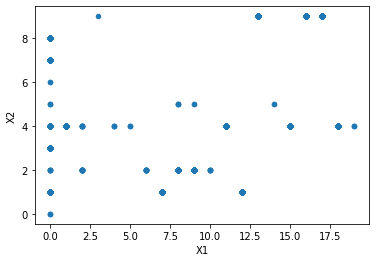

In [15]:
pet_train.plot(kind="scatter", x="X1", y="X2")
plt.show()

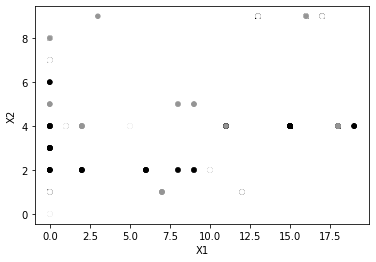

In [17]:
pet_train.plot(kind="scatter", x="X1", y="X2",alpha=1,c=pet_train["breed_category"])
plt.show()

## Looking for Correlations

In [18]:
df=pet_train.copy()
corr=df.corr()
print(corr['breed_category'].sort_values(ascending=False))
print(corr['pet_category'].sort_values(ascending=False))

breed_category    1.000000
X1                0.239556
pet_category      0.209646
X2                0.051608
height(cm)        0.015926
length(m)         0.005660
condition        -0.482912
Name: breed_category, dtype: float64
pet_category      1.000000
breed_category    0.209646
height(cm)        0.005169
length(m)        -0.007309
X2               -0.034942
X1               -0.038776
condition        -0.044034
Name: pet_category, dtype: float64


### Experimenting with Attribute Combinations

In [19]:
df=pet_train.copy()
df["Hcu"]=df["height(cm)"]**3
df["Lcu"]=df["length(m)"]**3
df["X1sq"]=df["X1"]**2
df["X2cb"]=df["X2"]**3
df["X1+X2"]=df["X1"]+df["X2"]

corr=df.corr()
print(corr['breed_category'].sort_values(ascending=False))
print(corr['pet_category'].sort_values(ascending=False))

breed_category    1.000000
X1sq              0.244552
X1                0.239556
pet_category      0.209646
X1+X2             0.193247
X2                0.051608
X2cb              0.027560
height(cm)        0.015926
Hcu               0.011409
Lcu               0.007944
length(m)         0.005660
condition        -0.482912
Name: breed_category, dtype: float64
pet_category      1.000000
breed_category    0.209646
Hcu               0.006547
height(cm)        0.005169
Lcu              -0.001929
length(m)        -0.007309
X1sq             -0.015391
X2               -0.034942
X1               -0.038776
X1+X2            -0.041587
condition        -0.044034
X2cb             -0.141203
Name: pet_category, dtype: float64


Some of them actually perform better than original ones, we can add them later

## Prepare the Data for Machine Learning Algorithms

In [20]:
pet_train_set = train_set.drop(['breed_category','pet_category'],axis=1).copy()
pet_labels_b = train_set["breed_category"].copy()
pet_labels_p = train_set["pet_category"].copy()

## Data Cleaning

In [41]:
pet_train.isnull().sum()

pet_id            0
issue_date        0
listing_date      0
condition         0
color_type        0
length(m)         0
height(cm)        0
X1                0
X2                0
breed_category    0
pet_category      0
dtype: int64

## Handling Text and Categorical Attributes

In [39]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
pet_train_cat.loc[pet_train_cat['condition'].isnull(),'condition']=3.0
pet_train_cat_1hot = cat_encoder.fit_transform(pet_train_cat) 
pet_train_cat_1hot

/Users/vivekkathula/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


<15067x60 sparse matrix of type '<class 'numpy.float64'>'
	with 30134 stored elements in Compressed Sparse Row format>

In [40]:
cat_encoder.categories_

[array([0., 1., 2., 3.]),
 array(['Agouti', 'Apricot', 'Black', 'Black Brindle', 'Black Smoke',
        'Black Tabby', 'Black Tiger', 'Blue', 'Blue Cream', 'Blue Merle',
        'Blue Point', 'Blue Smoke', 'Blue Tabby', 'Blue Tick',
        'Blue Tiger', 'Brown', 'Brown Brindle', 'Brown Merle',
        'Brown Tabby', 'Brown Tiger', 'Buff', 'Calico', 'Calico Point',
        'Chocolate', 'Chocolate Point', 'Cream', 'Cream Tabby', 'Fawn',
        'Flame Point', 'Gold', 'Gray', 'Gray Tabby', 'Green',
        'Lilac Point', 'Liver', 'Liver Tick', 'Lynx Point', 'Orange',
        'Orange Tabby', 'Pink', 'Red', 'Red Merle', 'Red Tick', 'Sable',
        'Seal Point', 'Silver', 'Silver Lynx Point', 'Silver Tabby', 'Tan',
        'Torbie', 'Tortie', 'Tortie Point', 'Tricolor', 'White', 'Yellow',
        'Yellow Brindle'], dtype=object)]

## Custom Transformers

In [23]:
from sklearn.base import BaseEstimator, TransformerMixin

l_ix , h_ix, X1_ix, X2_ix  = 0, 1, 2, 3

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_X1sq = True): # no *args or **kargs
        self.add_X1sq = add_X1sq 
    def fit(self, X, y=None):
        return self # nothing else to do 
    def transform(self, X):
        X1sq = X[:, X1_ix] **2
        X1plusX2= X[:, X1_ix]+X[:, X2_ix]
        Lcu = X[:, l_ix]**3
        Hcu = X[:, h_ix]**3
        X2cb = X[:, X2_ix] **3
        return np.c_[X, X1sq, X1plusX2,Lcu,Hcu,X2cb]

attr_adder = CombinedAttributesAdder()


## Transformation Pipelines, Feature Scaling

In [22]:
pet_train_num = pet_train_set.drop(["pet_id","issue_date","listing_date","condition","color_type"], axis=1)
pet_train_cat = pet_train_set[["condition","color_type"]]

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

pet_train_num_tr = num_pipeline.fit_transform(pet_train_num)

## Full Pipeline
replacing missing value in condition

In [32]:
X_train = pet_train.drop(['breed_category','pet_category'],axis=1).copy()
X_train.loc[X_train['condition'].isnull(),'condition']=3.0
y_train_b= pet_train["breed_category"].copy()
y_train_p = pet_train["pet_category"].copy()

In [33]:
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder

num_attribs = ['length(m)', 'height(cm)', 'X1', 'X2']
cat_attribs = ["condition","color_type"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])
     
X_train_tr = full_pipeline.fit_transform(X_train)

In [29]:
X_train_tr.shape

(15067, 69)

In [34]:
X_valid = pet_valid.drop(['breed_category','pet_category'],axis=1).copy()
X_valid.loc[X_valid['condition'].isnull(),'condition']=3.0
y_valid_b= pet_valid["breed_category"].copy()
y_valid_p = pet_valid["pet_category"].copy()

In [35]:
X_valid_tr = full_pipeline.transform(X_valid)

In [36]:
X_valid_tr.shape

(3767, 69)

## Select and Train a Model

### Training and Evaluating on the Training Set Using Cross-Validation

In [42]:
rf_clf_p = RandomForestClassifier()
rf_clf_b = RandomForestClassifier()

rf_clf_p.fit(X_train_tr, y_train_p)
rf_clf_b.fit(X_train_tr, y_train_b)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(rf_clf_p, X_train_tr, y_train_p,scoring="accuracy", cv=3)
print("Accuracy_p:  ",scores)
scores = cross_val_score(rf_clf_b, X_train_tr, y_train_b,scoring="accuracy", cv=3)
print("Accuracy_b:  ",scores)


Accuracy_p:   [0.86044197 0.85543608 0.84488252]
Accuracy_b:   [0.90224965 0.89207487 0.89685384]


In [44]:
y_pred_p = rf_clf_p.predict(X_valid_tr)
y_true_p = y_valid_p

y_pred_b = rf_clf_b.predict(X_valid_tr)
y_true_b = y_valid_b

from sklearn.metrics import f1_score
s1=f1_score(y_true_p, y_pred_p, average='weighted')
s2=f1_score(y_true_b, y_pred_b, average='weighted')
score=(s1+s2)/2
score

0.8728297182794238

In [43]:
gbm_clf_p = GradientBoostingClassifier()
gbm_clf_b = GradientBoostingClassifier()

gbm_clf_p.fit(X_train_tr, y_train_p)
gbm_clf_b.fit(X_train_tr, y_train_b)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(gbm_clf_p, X_train_tr, y_train_p,scoring="accuracy", cv=3)
print("Accuracy_p:  ",scores)
scores = cross_val_score(gbm_clf_b, X_train_tr, y_train_b,scoring="accuracy", cv=3)
print("Accuracy_b:  ",scores)


Accuracy_p:   [0.88214215 0.86758264 0.86638789]
Accuracy_b:   [0.90782401 0.89924333 0.8998407 ]


In [45]:
y_pred_p = gbm_clf_p.predict(X_valid_tr)
y_true_p = y_valid_p

y_pred_b = gbm_clf_b.predict(X_valid_tr)
y_true_b = y_valid_b

from sklearn.metrics import f1_score
s1=f1_score(y_true_p, y_pred_p, average='weighted')
s2=f1_score(y_true_b, y_pred_b, average='weighted')
score=(s1+s2)/2
score

0.8818765008797791

In [57]:
X_train_full = train.drop(['breed_category','pet_category'],axis=1).copy()
X_train_full.loc[X_train_full['condition'].isnull(),'condition']=3.0
y_train_full_b= train["breed_category"].copy()
y_train_full_p = train["pet_category"].copy()

In [47]:
X_train_full_tr = full_pipeline.fit_transform(X_train_full)

In [48]:
X_train_full_tr.shape

(18834, 69)

### Fine Tune using randomised search

In [50]:
#The report function below gives the rank-wise details of each model.

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidate = np.flatnonzero(results['rank_test_score'] == i)[0]
        print("Model with rank: {0}".format(i))
        print("Mean validation score: {0:.5f} (std: {1:.5f})".format(
            results['mean_test_score'][candidate],
            results['std_test_score'][candidate]))
        print("Parameters: {0}".format(results['params'][candidate]))
        print("")

In [54]:
model=GradientBoostingClassifier()

gbm_params={'n_estimators':[50,100,200,500],           
            'learning_rate': [0.01,.05,0.1,0.4,0.8,1],
            'max_depth':[1,2,3,4,5,6],
            'subsample':[0.5,0.8,1],
            'max_features':[0.1,0.3,0.5,0.8,1]
           }

random_search_b=RandomizedSearchCV(model,scoring='accuracy',
                                 param_distributions=gbm_params,
                                 cv=10,n_iter=10,
                                 n_jobs=-1,verbose=False)

random_search_b.fit(X_train_full_tr,y_train_full_b)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.4,
                                                          0.8, 1],
                                        'max_depth': [1, 2, 3, 4, 5, 6],
                                        'max_features': [0.1, 0.3, 0.5, 0.8, 1],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='accuracy', verbose=False)

In [55]:
report(random_search_b.cv_results_,3)

Model with rank: 1
Mean validation score: 0.90204 (std: 0.00763)
Parameters: {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.5, 'max_depth': 3, 'learning_rate': 0.01}

Model with rank: 2
Mean validation score: 0.90087 (std: 0.00749)
Parameters: {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.3, 'max_depth': 2, 'learning_rate': 0.05}

Model with rank: 3
Mean validation score: 0.89992 (std: 0.00509)
Parameters: {'subsample': 0.8, 'n_estimators': 500, 'max_features': 0.5, 'max_depth': 3, 'learning_rate': 0.4}



In [60]:
model=GradientBoostingClassifier()

gbm_params={'n_estimators':[75,100,125],           
            'learning_rate': [0.005,0.01,0.015,0.02],
            'max_depth':[3],
            'subsample':[0.5,0.8,1],
            'max_features':[0.5]
           }

random_search_b=RandomizedSearchCV(model,scoring='accuracy',
                                 param_distributions=gbm_params,
                                 cv=10,n_iter=10,
                                 n_jobs=-1,verbose=False)

random_search_b.fit(X_train_full_tr,y_train_full_b)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.005, 0.01, 0.015,
                                                          0.02],
                                        'max_depth': [3], 'max_features': [0.5],
                                        'n_estimators': [75, 100, 125],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='accuracy', verbose=False)

In [62]:
report(random_search_b.cv_results_,3)

Model with rank: 1
Mean validation score: 0.90220 (std: 0.00770)
Parameters: {'subsample': 0.5, 'n_estimators': 100, 'max_features': 0.5, 'max_depth': 3, 'learning_rate': 0.015}

Model with rank: 2
Mean validation score: 0.90204 (std: 0.00788)
Parameters: {'subsample': 1, 'n_estimators': 75, 'max_features': 0.5, 'max_depth': 3, 'learning_rate': 0.015}

Model with rank: 3
Mean validation score: 0.90204 (std: 0.00763)
Parameters: {'subsample': 0.8, 'n_estimators': 75, 'max_features': 0.5, 'max_depth': 3, 'learning_rate': 0.015}



In [58]:
model=GradientBoostingClassifier()

gbm_params={'n_estimators':[50,100,200,500],           
            'learning_rate': [0.01,.05,0.1,0.4,0.8,1],
            'max_depth':[1,2,3,4,5,6],
            'subsample':[0.5,0.8,1],
            'max_features':[0.1,0.3,0.5,0.8,1]
           }

random_search_p=RandomizedSearchCV(model,scoring='accuracy',
                                 param_distributions=gbm_params,
                                 cv=10,n_iter=10,
                                 n_jobs=-1,verbose=False)

random_search_p.fit(X_train_full_tr,y_train_full_p)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1, 0.4,
                                                          0.8, 1],
                                        'max_depth': [1, 2, 3, 4, 5, 6],
                                        'max_features': [0.1, 0.3, 0.5, 0.8, 1],
                                        'n_estimators': [50, 100, 200, 500],
                                        'subsample': [0.5, 0.8, 1]},
                   scoring='accuracy', verbose=False)

In [59]:
report(random_search_p.cv_results_,3)

Model with rank: 1
Mean validation score: 0.87671 (std: 0.01007)
Parameters: {'subsample': 1, 'n_estimators': 200, 'max_features': 0.8, 'max_depth': 3, 'learning_rate': 0.1}

Model with rank: 2
Mean validation score: 0.87650 (std: 0.00936)
Parameters: {'subsample': 0.5, 'n_estimators': 500, 'max_features': 1, 'max_depth': 3, 'learning_rate': 0.1}

Model with rank: 3
Mean validation score: 0.86880 (std: 0.00883)
Parameters: {'subsample': 1, 'n_estimators': 50, 'max_features': 1, 'max_depth': 3, 'learning_rate': 0.4}



In [63]:
model=GradientBoostingClassifier()

gbm_params={'n_estimators':[200,300,400],           
            'learning_rate': [0.05,0.1,0.15],
            'max_depth':[3],
            'subsample':[0.7,0.8,0.9],
            'max_features':[0.7,0.8,0.9]
           }

random_search_p=RandomizedSearchCV(model,scoring='accuracy',
                                 param_distributions=gbm_params,
                                 cv=10,n_iter=10,
                                 n_jobs=-1,verbose=False)

random_search_p.fit(X_train_full_tr,y_train_full_p)

RandomizedSearchCV(cv=10, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [3],
                                        'max_features': [0.7, 0.8, 0.9],
                                        'n_estimators': [200, 300, 400],
                                        'subsample': [0.7, 0.8, 0.9]},
                   scoring='accuracy', verbose=False)

In [64]:
report(random_search_p.cv_results_,3)

Model with rank: 1
Mean validation score: 0.87708 (std: 0.00879)
Parameters: {'subsample': 0.8, 'n_estimators': 300, 'max_features': 0.7, 'max_depth': 3, 'learning_rate': 0.1}

Model with rank: 2
Mean validation score: 0.87676 (std: 0.00913)
Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_features': 0.9, 'max_depth': 3, 'learning_rate': 0.15}

Model with rank: 3
Mean validation score: 0.87671 (std: 0.00989)
Parameters: {'subsample': 0.8, 'n_estimators': 200, 'max_features': 0.9, 'max_depth': 3, 'learning_rate': 0.1}



In [65]:
gbm_clf_b_final=random_search_b.best_estimator_

In [66]:
gbm_clf_p_final=random_search_p.best_estimator_

## Prediction on test

In [67]:
X_test=test.copy()
X_test.loc[X_test['condition'].isnull(),'condition']=3.0
X_test_tr = full_pipeline.transform(X_test)
X_train_tr.shape,X_test_tr.shape

((15067, 69), (8072, 69))

In [68]:
y_pred_p = rf_clf_p.predict(X_test_tr)

y_pred_b = rf_clf_b.predict(X_test_tr)

In [71]:
HE_Pet_submission=test[["pet_id"]].copy()
HE_Pet_submission["breed_category"]=y_pred_b
HE_Pet_submission["pet_category"]=y_pred_p

In [72]:
HE_Pet_submission.head(2)

,pet_id,breed_category,pet_category
0,ANSL_75005,1.0,2
1,ANSL_76663,0.0,1


### Save it for Submission

In [73]:
pd.DataFrame(HE_Pet_submission).to_csv("HE_Pet_submission.csv",index=False)